<a href="https://colab.research.google.com/github/SUPAGORN0306/229352-StatisticalLearning/blob/main/LAB09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!pip install numpy==1.26.4
!pip install pmdarima

In [2]:
# ONLY RUN THIS WHEN THERE IS AN ERROR
!pip install --user statsmodels==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 50.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-21 18:58:04--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.04s   

2025-09-21 18:58:04 (3.75 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [4]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA


In [5]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
# def parser(dates):
#   return pd.datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='coerce')

data = data.set_index('Date')

data.head()

,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [6]:
y = data['MaxTemp'].resample("ME").mean()
display(y.head())

,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [7]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [8]:
train = y[:-24]
test = y[-24:]

print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

def KPSStest(timeseries):
  kpsstest = kpss(timeseries)
  print('KPSS test')
  print('Test Statistic: ',kpsstest[0])
  print('p-value: ',kpsstest[1])
  print('Number of Observations Used: ',kpsstest[2])
  print('Critical Values: ',kpsstest[3])

def ADFtest(timeseries):
  adftest = adfuller(timeseries)
  print('ADF test')
  print('Test Statistic: ',adftest[0])
  print('p-value: ',adftest[1])
  print('#Lags Used: ',adftest[2])
  print('Number of Observations Used: ',adftest[3])
  print('Critical Values: ',adftest[4])

In [10]:
KPSStest(y)
ADFtest(y)

KPSS test
Test Statistic:  0.6428439386603282
p-value:  0.018741460121788345
Number of Observations Used:  4
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test
Test Statistic:  -2.222023197657817
p-value:  0.19834961731512274
#Lags Used:  13
Number of Observations Used:  245
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}


In [11]:
print(y)
print(y.shift())

Date
1998-01-31    31.687097
1998-02-28    33.685714
1998-03-31    37.103226
1998-04-30    37.910000
1998-05-31    35.848387
                ...    
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, Length: 259, dtype: float64
Date
1998-01-31          NaN
1998-02-28    31.687097
1998-03-31    33.685714
1998-04-30    37.103226
1998-05-31    37.910000
                ...    
2019-03-31    34.564286
2019-04-30    37.051613
2019-05-31    39.716667
2019-06-30    37.680645
2019-07-31    35.466667
Freq: ME, Name: MaxTemp, Length: 259, dtype: float64


In [12]:
y_diff = y-y.shift()
y_diff.dropna(inplace=True)

KPSStest(y_diff)
ADFtest(y_diff)

KPSS test
Test Statistic:  0.04516874529942415
p-value:  0.1
Number of Observations Used:  28
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
ADF test
Test Statistic:  -6.227064576112576
p-value:  5.0583827570587737e-08
#Lags Used:  12
Number of Observations Used:  245
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}


/tmp/ipython-input-3817557194.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries)


# ARIMA($p,d,q$)

ลองพล็อต ACF และ PACF ของ time series **ที่ผ่าน difference แล้ว**

1. ถ้า ACF ลดลงไปเรื่อยๆ และ PACF หายไปหลังจาก lag ใด lag หนึ่ง แสดงว่าค่าของ lag นั้นเป็นค่าอันดับ AR (นั่นคือค่า $p$) ที่เหมาะสม
2. ถ้า PACF ลดลงไปเรื่อยๆ และ ACF หายไปหลังจาก lag ใด lag หนึ่ง แสดงว่าค่าของ lag นั้นเป็นค่าอันดับ MA (นั่นคือค่า $q$) ที่เหมาะสม

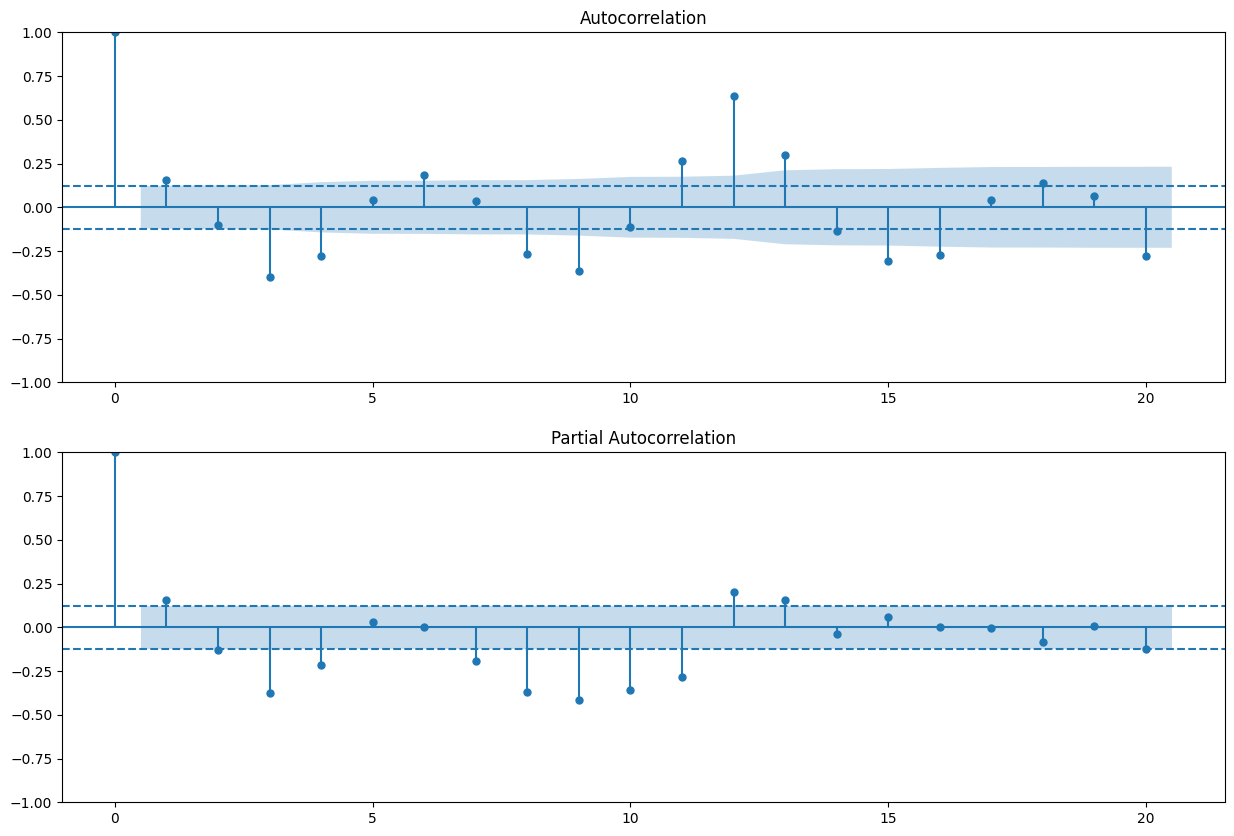

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1,figsize=(15, 10))

plot_acf(y_diff, lags=20, ax=ax[0]);
ax[0].axhline(y=-1.96/(len(y)-1)**.5, linestyle = '--')
ax[0].axhline(y=1.96/(len(y)-1)**.5, linestyle = '--')

plot_pacf(y_diff, lags=20, ax=ax[1]);
ax[1].axhline(y=-1.96/(len(y)-1)**.5, linestyle = '--')
ax[1].axhline(y=1.96/(len(y)-1)**.5, linestyle = '--')

In [14]:
train

,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387
...,...
2017-03-31,37.032258
2017-04-30,36.340000
2017-05-31,34.806452


In [15]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(0,1,3))

In [16]:
arima_fit = arima.fit()
yhat = arima_fit.predict(start=test.index[0], end=test.index[-1])

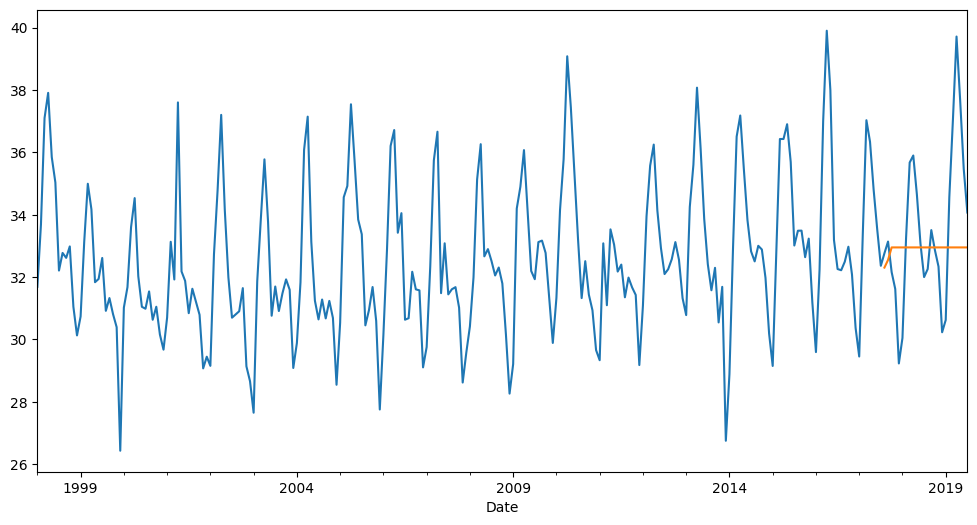

In [17]:
plt.figure(figsize=(12,6))
y.plot()
yhat.plot();

/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


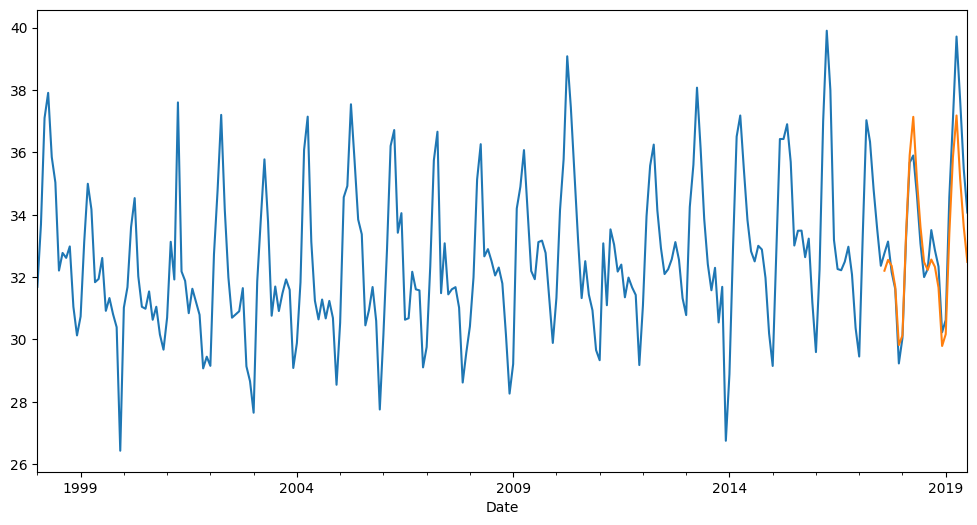

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit(optimized=True)

yhat = sarima_fit.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(12,6))
y.plot()
yhat.plot();


In [19]:
print("RMSE (SARIMA manual):", rmse(test, yhat))

RMSE (SARIMA manual): 1.0614795072052383


### ใช้ `auto_arima` จาก `pmdarima` เพื่อหา order ที่เหมาะสม

In [20]:
auto_fit = pm.auto_arima(train,
                         start_p=0, start_q=0, max_p=3, max_q=3,
                         seasonal=True, m=12,
                         start_P=0, start_Q=0, max_P=2, max_Q=2,
                         d=1, D=1,
                         information_criterion='aicc',
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,1,0)[12]             : AICC=861.244, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AICC=768.874, Time=0.17 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AICC=700.046, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AICC=799.244, Time=0.07 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AICC=inf, Time=0.70 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[12]             : AICC=inf, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AICC=748.519, Time=0.19 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[12]             : AICC=inf, Time=4.84 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[12]             : AICC=765.293, Time=0.28 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[12]             : AICC=697.708, Time=0.98 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,0)[12]             : AICC=inf, Time=2.20 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AICC=inf, Time=1.31 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[12]             : AICC=inf, Time=1.69 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AICC=744.812, Time=0.67 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : AICC=inf, Time=5.07 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AICC=726.602, Time=0.35 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12]             : AICC=697.210, Time=1.11 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[12]             : AICC=inf, Time=1.26 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[12]             : AICC=inf, Time=3.95 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,2)[12]             : AICC=698.418, Time=3.54 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12]             : AICC=inf, Time=1.70 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,2)[12]             : AICC=inf, Time=7.73 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[12]             : AICC=719.456, Time=0.58 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,1)[12]             : AICC=699.193, Time=1.66 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AICC=698.077, Time=2.15 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AICC=696.200, Time=1.42 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,0)[12]             : AICC=inf, Time=0.82 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,1)[12]             : AICC=inf, Time=1.36 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : AICC=inf, Time=3.67 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[12]             : AICC=inf, Time=2.81 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,2)[12]             : AICC=inf, Time=6.81 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[12]             : AICC=698.852, Time=0.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,1)[12]             : AICC=698.124, Time=4.31 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,1,1)[12]             : AICC=698.296, Time=1.26 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,1,1)[12]             : AICC=700.294, Time=3.59 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12] intercept   : AICC=inf, Time=2.89 sec

Best model:  ARIMA(1,1,2)(0,1,1)[12]          
Total fit time: 73.327 seconds


In [21]:
print(auto_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  235
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -342.969
Date:                              Sun, 21 Sep 2025   AIC                            695.938
Time:                                      19:00:19   BIC                            712.951
Sample:                                  01-31-1998   HQIC                           702.807
                                       - 07-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7743      0.106      7.337      0.000       0.567       0.981
ma.L1         -1.42

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


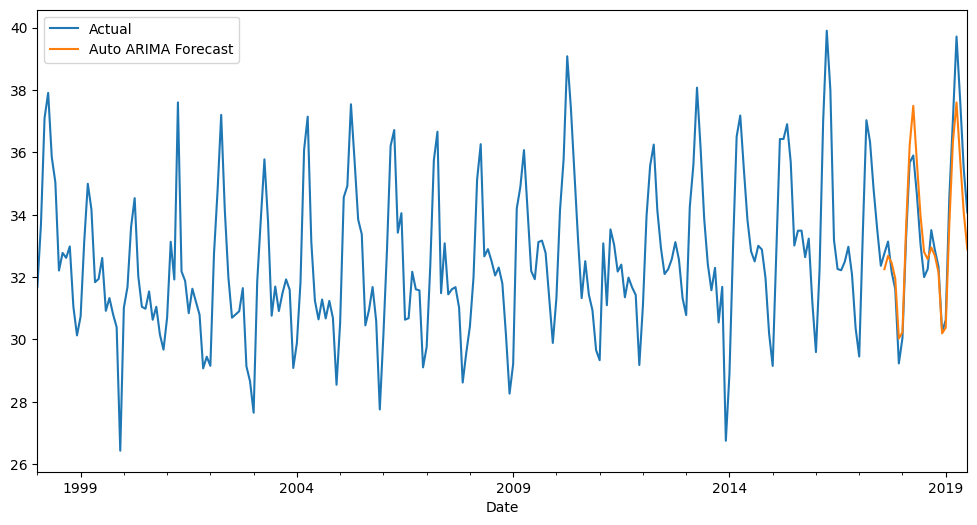

In [22]:
predictions = auto_fit.predict(n_periods=24)
yhat_auto = pd.Series(predictions, index=test.index)

plt.figure(figsize=(12,6))
y.plot(label="Actual")
yhat_auto.plot(label="Auto ARIMA Forecast")
plt.legend()
plt.show()

In [23]:
print("RMSE (Auto ARIMA):", rmse(test, yhat_auto))

RMSE (Auto ARIMA): 0.9135768120363086
